In [ ]:
# SYSTEM CHECK
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Eager execution:", tf.executing_eagerly())

import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from glob import glob


## Setup

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 14
EPOCHS = 5

CLASSES = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion",
    "Emphysema", "Fibrosis", "Infiltration", "Mass", "Nodule",
    "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Hernia"
]

CSV_PATH = "/kaggle/input/data/Data_Entry_2017.csv"
IMAGE_PATHS = glob(os.path.join("/kaggle/input/data", "images*", "*", "*.png"))
all_image_paths = {os.path.basename(x): x for x in IMAGE_PATHS}
#READ CSV
df = pd.read_csv(CSV_PATH)
df = df.rename(columns={"Image Index": "image", "Finding Labels": "labels"})
df = df[df["image"].isin(all_image_paths)]
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

In [13]:
def encode_labels(label_str, class_list):
    label_vec = np.zeros(len(class_list), dtype=np.float32)
    for label in label_str.split('|'):
        if label in class_list:
            label_vec[class_list.index(label)] = 1.0
    return label_vec
    
def create_df(df, image_path_dict, classes):
    image_paths = []
    labels = []

    for _, row in df.iterrows():
        path = image_path_dict.get(row["image"])
        if path is not None:
            image_paths.append(path)
            labels.append(encode_labels(row["labels"], classes))

    df_out = pd.DataFrame({'image_path': image_paths, 'label': labels})
    return df_out


In [14]:
train_data = create_df(train_df, all_image_paths, CLASSES)
val_data = create_df(val_df, all_image_paths, CLASSES)


In [15]:
def process_sample(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.keras.applications.densenet.preprocess_input(img)
    return img, label

def build_dataset(df, batch_size=32, shuffle=True):
    paths = df["image_path"].values
    labels = np.stack(df["label"].values)

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda x, y: process_sample(x, y), num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


## Create Datasets

In [16]:
train_ds = build_dataset(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_ds = build_dataset(val_data, batch_size=BATCH_SIZE, shuffle=False)


## Model Setup

In [17]:
local_weights_path = "/kaggle/input/densenet121/keras/default/1/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"

base_model = DenseNet121(include_top=False, weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.load_weights(local_weights_path)
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
out = Dense(NUM_CLASSES, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=out)

from tensorflow.keras.metrics import AUC

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[AUC(multi_label=True, name='auc')]
)

#model.summary()


## Training

In [18]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
)

model.save("/kaggle/working/xray_densenet_model_modelsave.h5")

from tensorflow.keras.models import save_model
save_model(model, "/kaggle/working/xray_densenet_model.h5")

Epoch 1/5
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 821s 251ms/step - auc: 0.5904 - loss: 0.2025 - val_auc: 0.7284 - val_loss: 0.1684
Epoch 2/5
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 769s 239ms/step - auc: 0.6578 - loss: 0.1780 - val_auc: 0.7195 - val_loss: 0.1673
Epoch 3/5
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 784s 244ms/step - auc: 0.6622 - loss: 0.1778 - val_auc: 0.7251 - val_loss: 0.1680
Epoch 4/5
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 763s 237ms/step - auc: 0.6640 - loss: 0.1775 - val_auc: 0.7267 - val_loss: 0.1689
Epoch 5/5
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 791s 246ms/step - auc: 0.6670 - loss: 0.1775 - val_auc: 0.7257 - val_loss: 0.1674


In [19]:
#plt.plot(history.history['accuracy'], label='Train Accuracy')
#plt.plot(history.history['val_accuracy'], label='Val Accuracy')
#plt.plot(history.history['loss'], label='Train Loss')
#plt.plot(history.history['val_loss'], label='Val Loss')
#plt.title('Training History')
#plt.xlabel('Epoch')
#plt.ylabel('Value')
#plt.legend()
#plt.grid(True)
#plt.show()


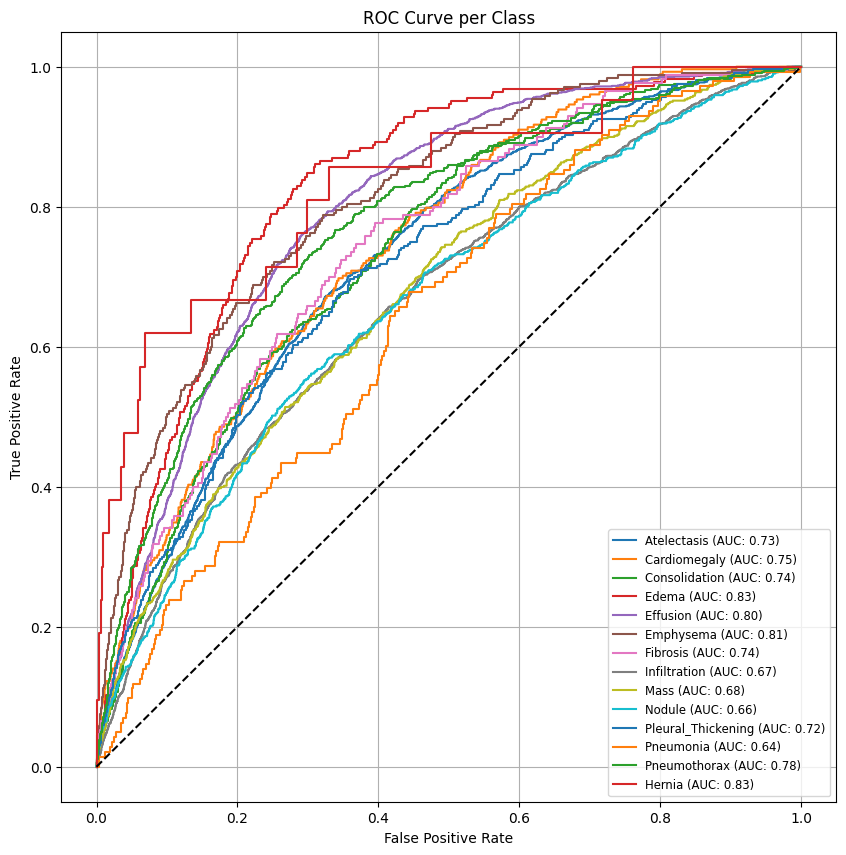

                    precision    recall  f1-score   support

       Atelectasis       0.00      0.00      0.00      1112
      Cardiomegaly       0.00      0.00      0.00       278
     Consolidation       0.00      0.00      0.00       414
             Edema       0.00      0.00      0.00       223
          Effusion       1.00      0.00      0.01      1351
         Emphysema       0.33      0.00      0.01       240
          Fibrosis       0.00      0.00      0.00       170
      Infiltration       0.44      0.02      0.03      2003
              Mass       0.00      0.00      0.00       578
            Nodule       0.00      0.00      0.00       616
Pleural_Thickening       0.00      0.00      0.00       320
         Pneumonia       0.00      0.00      0.00       143
      Pneumothorax       0.00      0.00      0.00       518
            Hernia       0.00      0.00      0.00        21

         micro avg       0.46      0.01      0.01      7987
         macro avg       0.13      0.0

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report

# if needed
model = tf.keras.models.load_model("/kaggle/working/xray_densenet_model.h5")

# Rebuild val_ds if needed (if notebook restarted)
# val_ds = build_dataset(val_data, batch_size=BATCH_SIZE, shuffle=False)

# Predict and collect labels
y_true, y_pred = [], []
for batch_x, batch_y in val_ds:
    pred_batch = model.predict(batch_x, verbose=0)
    y_pred.append(pred_batch)
    y_true.append(batch_y)

# Combine batches
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

# --- ROC Curve per class ---
plt.figure(figsize=(10, 10))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{CLASSES[i]} (AUC: {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve per Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize='small', loc='lower right')
plt.grid(True)
plt.show()

# --- Classification Report ---
y_pred_bin = (y_pred > 0.5).astype(int)
report = classification_report(y_true, y_pred_bin, target_names=CLASSES, zero_division=0)
print(report)

# Optional: save report to file
with open("classification_report.txt", "w") as f:
    f.write(report)
